In [7]:
import numpy as np 
import pandas as pd
import cplex # community edition
import matplotlib.pyplot as plt

In [8]:
arg_source = pd.read_csv('D:/jupyter_dir/yancao/data/step1.csv')
arg_source.head()

# 参数和决策变量
price = arg_source['单箱价格'].values
sold = arg_source['上期销售量'].values 
cap = arg_source['产能'].values

sold_obj = 2300   # 目标销量(箱)
price_obj = 40000 # 目标结构(元/箱)
C = 10000

注：此示例数据中，本期销售总量2163箱，销售结构43261元/箱

In [59]:
# lp文件生成
# sold_next --> x(0) x(1) ...

var = [i for i in map(lambda x: 'x(' + str(x) + ')', list(range(arg_source.shape[0])))] # ['x(1)', 'x(2)', ...]
price_sold_sum = ''

for i in range(len(cap)):
    price_sold_sum += ' + %s x(%s)'%(price[i]/250, i)

lp = "Minimize\n obj: "
for i in range(len(cap)):
    lp += ' - %s x(%s)'%(500*sold_obj+2*C/sold[i], i)

lp += '\n+ ['
for i in range(len(cap)):
    lp += ' + %s x(%s)^2'%(2*C/sold[i]**2 + 2, i)
    for j in range(i+1, len(cap)):
        lp += ' + 4 x(%s) * x(%s)'%(i,j)
    lp += '\n'

lp += ']/2\n'

lp += ' + %s'%(sold_obj**2 + C*len(cap))

lp += '\nSubject To\n'
lp += ' c1: %s >= %s \n'%(price_sold_sum, 0.9*sold_obj*price_obj)
lp += ' c2: %s <= %s \n'%(price_sold_sum, 1.1*sold_obj*price_obj)
for i in range(len(cap)):
    lp += ' c%s: x(%s) - Rgc%s = 0\n'%(3+i, i, i)
lp += 'Bounds\n'
for i in range(len(cap)): 
    lp += 'x(%s) Free\n'%i
for i in range(len(cap)): 
    lp += ' 0 <= Rgc%s <= %s \n'%(i, cap[i])
lp += 'General\n'
for i in range(len(cap)): lp += ' %s'%(var[i])
lp += '\nEnd'

with open('write.lp', 'w') as f:
    f.write(lp)

# ---------------------------------------------

my_prob = cplex.Cplex('write.lp')
my_prob.solve()

x = my_prob.solution.get_values()
sold_next = np.array(x, dtype='int')[0:int(len(x)/2)]

Version identifier: 12.10.0.0 | 2019-11-27 | 843d4de2ae
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
MIQP Presolve eliminated 71 rows and 71 columns.
MIQP Presolve modified 2 coefficients.
Reduced MIQP has 2 rows, 71 columns, and 142 nonzeros.
Reduced MIQP has 0 binaries, 71 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 5041 nonzeros.
Presolve time = 0.02 sec. (0.59 ticks)
Tried aggregator 1 time.
Reduced MIQP has 2 rows, 71 columns, and 142 nonzeros.
Reduced MIQP has 0 binaries, 71 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 5041 nonzeros.
Presolve time = 0.00 sec. (0.45 ticks)
Classifier predicts products in MIQP should be linearized.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.03 sec. (9.09 ticks)

        Nodes                                         Cuts/
   Node  Left   

In [119]:
# 销量偏差百分比
delta_sold = (sold_obj - sold_next.sum()/250)/sold_obj
delta_price = (price_obj - (sold_next*price).sum()/(sold_next.sum()))/price_obj
delta_sale = (sold_obj*price_obj - (sold_next*price).sum()/250)/(sold_obj*price_obj)
delta_change = ((sold_next-sold)/sold).mean()
print('销量偏差：%.2f \n结构偏差：%.2f\n销售额偏差：%.2f\n销量变动程度：%.2f'%(delta_sold, delta_price, delta_sale, delta_change))

销量偏差：0.00 
结构偏差：-0.03
销售额偏差：-0.03
销量变动程度：0.01


### 封装成函数

In [120]:
def model(sold_obj, price_obj):
    var = [i for i in map(lambda x: 'x(' + str(x) + ')', list(range(arg_source.shape[0])))] # ['x(1)', 'x(2)', ...]
    price_sold_sum = ''
    for i in range(len(cap)):
        price_sold_sum += ' + %s x(%s)'%(price[i]/250, i)

    lp = "Minimize\n obj: "
    for i in range(len(cap)):
        lp += ' - %s x(%s)'%(500*sold_obj+2*C/sold[i], i)

    lp += '\n+ ['
    for i in range(len(cap)):
        lp += ' + %s x(%s)^2'%(2*C/sold[i]**2 + 2, i)
        for j in range(i+1, len(cap)):
            lp += ' + 4 x(%s) * x(%s)'%(i,j)
        lp += '\n'

    lp += ']/2\n'

    lp += ' + %s'%(sold_obj**2 + C*len(cap))

    lp += '\nSubject To\n'
    lp += ' c1: %s >= %s \n'%(price_sold_sum, 0.9*sold_obj*price_obj)
    lp += ' c2: %s <= %s \n'%(price_sold_sum, 1.1*sold_obj*price_obj)
    for i in range(len(cap)):
        lp += ' c%s: x(%s) - Rgc%s = 0\n'%(3+i, i, i)
    lp += 'Bounds\n'
    for i in range(len(cap)): 
        lp += 'x(%s) Free\n'%i
    for i in range(len(cap)): 
        lp += ' 0 <= Rgc%s <= %s \n'%(i, cap[i])
    lp += 'General\n'
    for i in range(len(cap)): lp += ' %s'%(var[i])
    lp += '\nEnd'

    with open('write.lp', 'w') as f:
        f.write(lp)
    
    my_prob = cplex.Cplex('write.lp')
    try:
        my_prob.solve()
        x = my_prob.solution.get_values()
    except:
        return np.nan, np.nan, np.nan, np.nan
        
    sold_next = np.array(x, dtype='int')[0:int(len(x)/2)]

    # 销量偏差百分比
    delta_sold = (sold_obj - sold_next.sum()/250)/sold_obj
    delta_price = (price_obj - (sold_next*price).sum()/(sold_next.sum()))/price_obj
    delta_sale = (sold_obj*price_obj - (sold_next*price).sum()/250)/(sold_obj*price_obj)
    delta_change = ((sold_next-sold)/sold).mean()
    return delta_sold, delta_price, delta_sale, delta_change

In [122]:
# 网格调优
ev_set = np.zeros([10,10,4])

for s in range(10):
    for p in range(10):
        ev_set[s,p] = model(sold_obj=1000+s*200, price_obj=30000+p*2000)

d 2 coefficients.
Reduced MIQP has 2 rows, 71 columns, and 142 nonzeros.
Reduced MIQP has 0 binaries, 71 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 5041 nonzeros.
Presolve time = 0.02 sec. (0.59 ticks)
Tried aggregator 1 time.
Reduced MIQP has 2 rows, 71 columns, and 142 nonzeros.
Reduced MIQP has 0 binaries, 71 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 5041 nonzeros.
Presolve time = 0.02 sec. (0.45 ticks)
Classifier predicts products in MIQP should be linearized.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.03 sec. (3.39 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

      0     0  -4.22108e+11     1                -4.22108e+11       14         
*     0+    0                      -4.22108e+11  -4.22108e

Text(0.5, 60.0, 'price_obj')

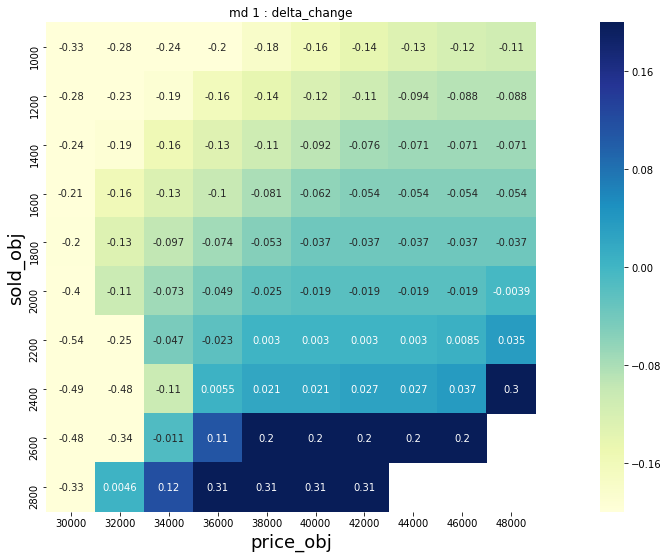

In [143]:
# 可视化delta_sold, delta_price, delta_sale, delta_change

hm_data = pd.DataFrame(ev_set[:,:,3])
hm_data.index = [1000+s*200 for s in range(10)]
hm_data.columns = Y = [30000+p*2000 for p in range(10)]

import seaborn as sns
fig, ax = plt.subplots(figsize = (23,9))
sns.heatmap(hm_data, annot=True, vmax=0.2,vmin = -0.2, xticklabels= True,yticklabels= True, square=True, cmap="YlGnBu")

ax.set_title('md 1 : delta_change')
ax.set_ylabel('sold_obj', fontsize = 18)
ax.set_xlabel('price_obj', fontsize = 18)